In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf

# # LaTeX style plots
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 10,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10
#     }
# plt.rcParams.update(tex_fonts)

# Read in data, split into train and test sets

In [2]:
# read in data and convert time axis to datetime
df = pd.read_csv('../air_weather_data/pollution_and_weather_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M')
df = df.set_index('Date')

In [3]:
np.sum(df.iloc[:,:] < 0);

# Replace <= 0 pollution values with NaNs then linearly interpolate

In [4]:
# df.iloc[:,:7][df.iloc[:,:7] <= 0] = np.NaN
# df.interpolate(inplace=True)

In [5]:
# np.sum(df.iloc[:,:].isna())
# np.sum(df.iloc[:,:] <= 0)

In [6]:
# df.iloc[:,:7] = np.sqrt(df.iloc[:,:7])

In [7]:
# df.describe()

# Create lagged values of all pollutants

In [8]:
df['PM$_{10}$, Torkel Knutssonsgatan, lag 1'] = df['PM$_{10}$, Torkel Knutssonsgatan'].shift(1)
df['PM$_{2.5}$, Torkel Knutssonsgatan, lag 1'] = df['PM$_{2.5}$, Torkel Knutssonsgatan'].shift(1)
df['NO$_2$, Torkel Knutssonsgatan, lag 1'] = df['NO$_2$, Torkel Knutssonsgatan'].shift(1)

df['PM$_{10}$, Hornsgatan, lag 1'] = df['PM$_{10}$, Hornsgatan'].shift(1)
df['PM$_{2.5}$, Hornsgatan, lag 1'] = df['PM$_{2.5}$, Hornsgatan'].shift(1)

df['PM$_{10}$, Norr Malma, lag 1'] = df['PM$_{10}$, Norr Malma'].shift(1)
df['PM$_{2.5}$, Norr Malma, lag 1'] = df['PM$_{2.5}$, Norr Malma'].shift(1)

df = df.dropna() # dropping first row which now contains nan values

# drop all non-lagged pollution variables which are not to be forecasted
df = df.drop([
              # 'PM$_{10}$, Torkel Knutssonsgatan', 
              'PM$_{2.5}$, Torkel Knutssonsgatan',
              'NO$_2$, Torkel Knutssonsgatan',
              'PM$_{10}$, Hornsgatan',
              'PM$_{2.5}$, Hornsgatan',
              'PM$_{10}$, Norr Malma',
              'PM$_{2.5}$, Norr Malma',
              # 'Temperature',
              # 'Atmospheric pressure',
              # 'Relative humidity',
              # 'Precipitation',
              # 'Solar radiation',
              # 'Wind speed',
              # 'sine day', 'cosine day', 'sine week', 'cosine week', 'sine year','cosine year'
              ],axis=1)
df.head(1)

,"PM$_{10}$, Torkel Knutssonsgatan",Temperature,Atmospheric pressure,Relative humidity,Precipitation,Solar radiation,Wind speed,sine day,cosine day,sine week,cosine week,sine year,cosine year,"PM$_{10}$, Torkel Knutssonsgatan, lag 1","PM$_{2.5}$, Torkel Knutssonsgatan, lag 1","NO$_2$, Torkel Knutssonsgatan, lag 1","PM$_{10}$, Hornsgatan, lag 1","PM$_{2.5}$, Hornsgatan, lag 1","PM$_{10}$, Norr Malma, lag 1","PM$_{2.5}$, Norr Malma, lag 1"
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01 02:00:00,8.5,3.27575,1008.85,99.95,0.0,0.0005,5.293,0.5,0.866025,0.07473,0.997204,0.002939,0.999996,28.4,22.9,4.5,32.5,15.1,7.7,3.8


In [9]:
# '2016-01-01 00:00:00'

# split to train and test set
df_train = df[:'2019-01-01 00:00:00']
df_test = df['2021-01-01 00:00:00':]

# MinMax normalize train and test data 

In [10]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()

# normalize and make dataframe of training set
df_train = scaler.fit_transform(df_train.values)
df_train = pd.DataFrame(df_train, columns=df.columns)

# normalize test set with statistics from training data, and make dataframe
df_test = scaler.transform(df_test.values)
df_test = pd.DataFrame(df_test, columns=df.columns)

# inversed = scaler.inverse_transform(df_train_norm) # inverse normalization
# df_train_norm['PM$_{2.5}$, Torkel Knutssonsgatan']
# df_train_norm.head(3)

In [11]:
# d = pd.DataFrame({'a':np.arange(2,7), 'b':np.arange(3,8), 'c':np.arange(4,9)})
# d_ = scaler.fit_transform(d)
# d_ = pd.DataFrame(d_, columns = d.columns)
# scaler.inverse_transform(d_), d

# Split into X and y 

In [12]:
# training set
y = df_train[[
             'PM$_{10}$, Torkel Knutssonsgatan',
            #  'PM$_{2.5}$, Torkel Knutssonsgatan'
            #  'NO$_2$, Torkel Knutssonsgatan',
            #  'PM$_{10}$, Hornsgatan'
            ]]

X = df_train.drop([
                   'PM$_{10}$, Torkel Knutssonsgatan',
                  #  'PM$_{2.5}$, Torkel Knutssonsgatan'
                  #  'PM$_{2.5}$, Torkel Knutssonsgatan',
                  # 'PM$_{10}$, Hornsgatan'
                  ], axis=1)

# test set
y_test = df_test[[
                 'PM$_{10}$, Torkel Knutssonsgatan',
               #   'PM$_{2.5}$, Torkel Knutssonsgatan'
                #  'NO$_2$, Torkel Knutssonsgatan'
                # 'PM$_{10}$, Hornsgatan'
                 ]]

X_test = df_test.drop([
                       'PM$_{10}$, Torkel Knutssonsgatan',
                    #    'NO$_2$, Torkel Knutssonsgatan'
                     #   'PM$_{2.5}$, Torkel Knutssonsgatan'
                    #    'PM$_{2.5}$, Torkel Knutssonsgatan',
                      #  'PM$_{10}$, Hornsgatan'
                      ], axis=1)



# Fit a ridge regression model

In [31]:
from itertools import chain

# PM10
n_alphas = 50
alphas = np.logspace(-2, 4, n_alphas)
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X, y)
    coefs.append(list(chain(*ridge.coef_)))

In [32]:
np.shape(coefs)

(50, 19)

0.1757510624854792


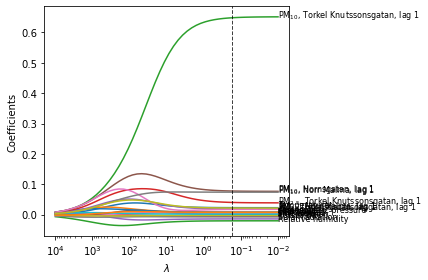

In [36]:
# select value of lambda with cross-validation
from sklearn.model_selection import GridSearchCV
pars = {'alpha':np.logspace(-1, 1, n_alphas)}
rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
rr.fit(X, y)

bestalpha = rr.best_params_['alpha']
print(bestalpha)

# ridge trace plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(-.2,.55)

for i in range(len(X.columns)):
    plt.text(min(alphas), coefs[0][i], X.columns[i], fontsize=8)

plt.xlabel(r'$\lambda$')
plt.ylabel('Coefficients')
plt.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
plt.tight_layout()
plt.savefig('../plots/PM10_ridge_regression.pdf')

In [24]:
rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
rrbest.fit(X, y)
(np.sqrt(mean_squared_error(rrbest.predict(X), y)).round(5), 
np.sqrt(mean_squared_error(rrbest.predict(X_test), y_test)).round(5)
)

(0.02719, 0.02192)

# Fit a lasso regression model

In [28]:
n_alphas = 50
alphas = np.logspace(-10, 2, n_alphas)
lasso = linear_model.Lasso()
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

lassocv = linear_model.LassoCV(cv=10)
lassocv.fit(X, y)
lassocv.alpha_

/Users/simoncarlen/opt/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4.7611372083408074e-06

In [29]:
np.shape(coefs)

(50, 19)

In [25]:
np.min(lassocv.alphas_), np.max(lassocv.alphas_)

(3.6016256955656445e-06, 0.0036016256955656483)

In [26]:
np.shape(coefs)

(50, 19)

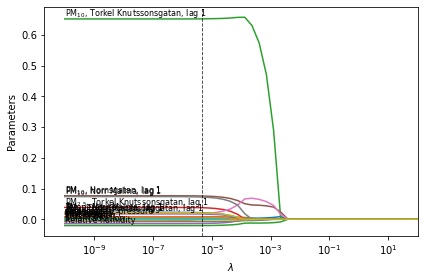

In [27]:
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlim(min(alphas)/5, max(alphas))
ax.set_xscale('log')

for i in range(len(X.columns)):
    plt.text(min(alphas), coefs[0][i]+0.01, X.columns[i], fontsize=8)

plt.axvline(lassocv.alpha_, color='k', linewidth=.9, linestyle='--', alpha=.75)
plt.xlabel(r'$\lambda$')
plt.ylabel('Parameters')
plt.tight_layout()
# plt.savefig('../plots/PM10_lasso_reg.pdf')

In [42]:
# coefs chosen by lasso model
for i, j in zip(X.columns, lassocv.coef_.round(3)):
    print(i,':  ', j)

Temperature :   0.021
Atmospheric pressure :   0.008
Relative humidity :   -0.021
Precipitation :   -0.0
Solar radiation :   -0.014
Wind speed :   0.0
sine day :   0.005
cosine day :   -0.008
sine week :   -0.002
cosine week :   0.002
sine year :   0.008
cosine year :   0.007
PM$_{10}$, Torkel Knutssonsgatan, lag 1 :   0.652
PM$_{2.5}$, Torkel Knutssonsgatan, lag 1 :   0.038
NO$_2$, Torkel Knutssonsgatan, lag 1 :   0.017
PM$_{10}$, Hornsgatan, lag 1 :   0.076
PM$_{2.5}$, Hornsgatan, lag 1 :   0.019
PM$_{10}$, Norr Malma, lag 1 :   0.072
PM$_{2.5}$, Norr Malma, lag 1 :   0.02


In [43]:
np.sqrt(mean_squared_error(lasso.predict(X), y)).round(5), np.sqrt(mean_squared_error(lasso.predict(X_test), y_test)).round(5)

(0.05275, 0.04913)